In [1]:
from vtk import *
from vtk.util import numpy_support as VN
import meshio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import linecache
import os
import sciPyFoam.polyMesh2d as mesh2d
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
dpi=600
fig_fmt=['svg']
# path----------
path_figures='../../../../../_figures'

## 1. Read and plot mesh information

Please use command `pip install sciPyFoam` to install a usefull python package to read polyMesh and plot mesh topology.

There are 5 functions are available in `sciPyFoam.polyMesh`
1. `x, y, z, cells_rect=mesh2d.readInternal('case/VTK/case_0.vtk')`
2. `faces = readFaces(caseDir)`
3. `owners = readOwner(caseDir)`
4. `neighbours = readNeighbour(caseDir)`
5. `boundaries, index_internalFaces, name_faces = readBoundary(caseDir,nFaces)`

**Interesting and smart design! the internal face index is consecutive and from zero.**

nPoints: 132, nPoints_2D: 66, nCells: 50
nBoundaries: 5,  ['left', 'right', 'top', 'bottom', 'frontAndBack']
nInternalFaces: 85


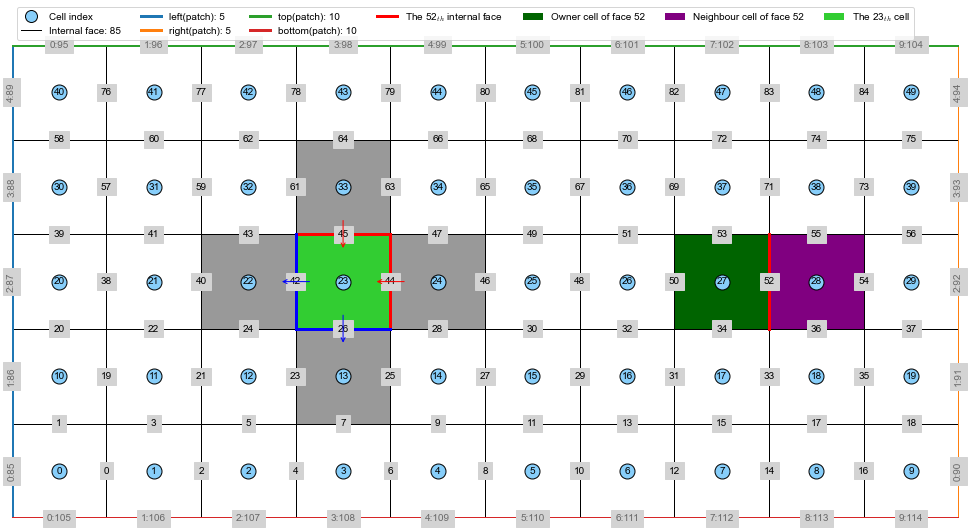

In [3]:
caseName='regularBox'
caseDir='../'

# plot 
fig=plt.figure(figsize=(14, 7))
ax=plt.gca()
ax.axis('scaled')
x,y,z,cells_rect,faces,boundaries,owners,neighbours=mesh2d.plotMeshTopology(ax,caseDir,ind_cell=23,index_intFace=52,lw=3)
# set axis
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.axis('off')
plt.tight_layout()
leg=ax.legend(ncol=7,loc='lower left', bbox_to_anchor=[0,1])
leg.legendHandles[0]._legmarker.set_markersize(12)
fname_fig= lambda fmt: str('%s/mesh_FVM_%s.%s'%(path_figures,caseName,fmt))
for fmt in fig_fmt:
    plt.savefig(fname_fig(fmt),dpi=dpi,bbox_inches='tight')

plt.show()

In [5]:
# x, y, z, cells_rect=mesh2d.readInternal(caseDir)
# faces = mesh2d.readFaces(caseDir)
# owners = mesh2d.readOwner(caseDir)
# neighbours = mesh2d.readNeighbour(caseDir)
# boundaries, index_internalFaces, name_faces = mesh2d.readBoundary(caseDir,len(faces['nNodes']))